In [6]:
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
raw_path = "../../../../NewProject/alternative data/"
loan_default_df = pd.read_csv(raw_path + "hmeq.csv")

In [24]:
loan_default_df.shape
#loan_default_df = loan_default_df.drop('LoanID',axis=1)

(5960, 13)

In [29]:
import numpy as np
#separating numerical and categorical variables - for statistics
#loan_default = loan_default_df.drop(["LoanID"], axis=1)
categorical_columns = ['BAD','REASON','JOB']
loan_default_df_num = loan_default_df.drop(categorical_columns, axis=1)

numerical_columns = ['LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC']
loan_default_df_cat = loan_default_df.drop(numerical_columns, axis=1)

loan_default_df_num.mean().values


array([1.86079698e+04, 7.37608172e+04, 1.01776049e+05, 8.92226814e+00,
       2.54569688e-01, 4.49442379e-01, 1.79766275e+02, 1.18605505e+00,
       2.12960962e+01, 3.37799153e+01])

In [30]:
#statistics of numerical variables
num_stats =np.vstack((np.append('variable',np.array(numerical_columns)),
                    np.append('max',loan_default_df_num.max().values),
                    np.append('min',loan_default_df_num.min().values),
                    np.append('mean',loan_default_df_num.mean().values),
                    np.append('median',loan_default_df_num.median().values),
                    np.append('st dev',loan_default_df_num.std().values),
                    np.append('skew', loan_default_df_num.skew().values),
                    np.append('kurtosis', loan_default_df_num.kurtosis().values)))
num_stats = pd.DataFrame(data=num_stats[1:,1:],
                         index=num_stats[1:,0],
                         columns=num_stats[0,1:])
num_stats

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
max,89900.0,399550.0,855909.0,41.0,10.0,15.0,1168.2335609,17.0,71.0,203.31214869
min,1100.0,2063.0,8000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5244992154
mean,18607.96979865772,73760.817199559,101776.04874145007,8.922268135904499,0.2545696877380046,0.4494423791821561,179.76627518656605,1.1860550458715597,21.29609620076682,33.779915348721126
median,16300.0,65019.0,89235.5,7.0,0.0,0.0,173.46666667,1.0,20.0,34.818261819
st dev,11207.480416694003,44457.60945841593,57385.775333702615,7.573982248898866,0.8460467770863184,1.1272659176049724,85.81009176356652,1.728674971208052,10.138933192458635,8.60174618632853
skew,2.023780711662712,1.8144807024145053,3.053344266520436,0.988460069460924,5.320870250335324,4.023149577223611,1.3434120433858243,2.6219841722623216,0.7750517582950025,2.8523534162154887
kurtosis,6.932589768131475,6.481866313861641,24.362804878699166,0.372072478946083,36.87276338780535,23.56544868259093,7.599549329190449,9.786507277872843,1.1576727319132387,50.50404153094317


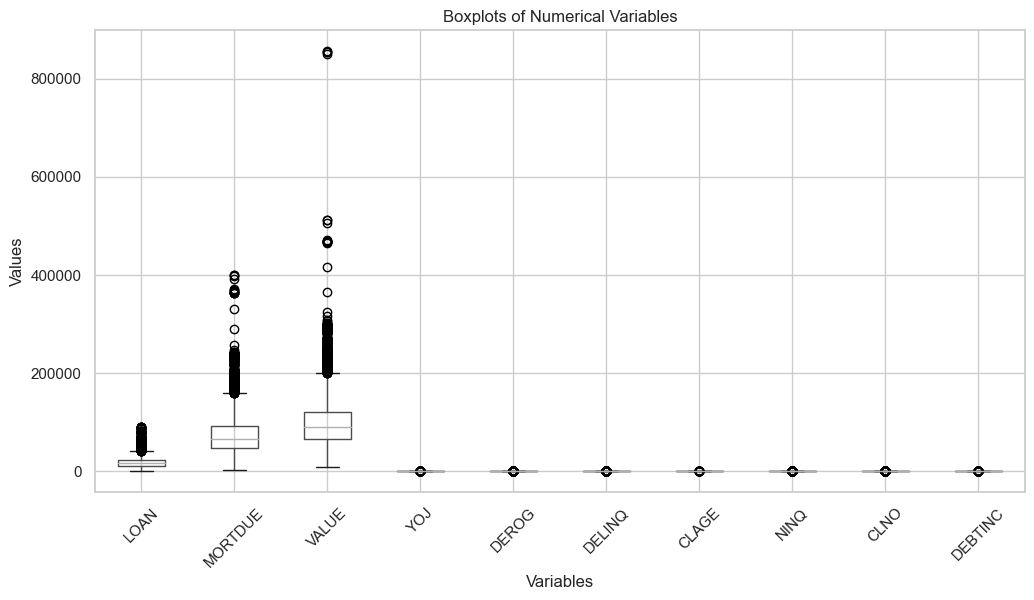

In [31]:
# Assuming loan_default_df is your DataFrame

# Specify the numerical columns for which you want to create boxplots
numerical_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

# Create boxplots for each numerical column
loan_default_df_num[numerical_columns].boxplot(figsize=(12, 6))
plt.title('Boxplots of Numerical Variables')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

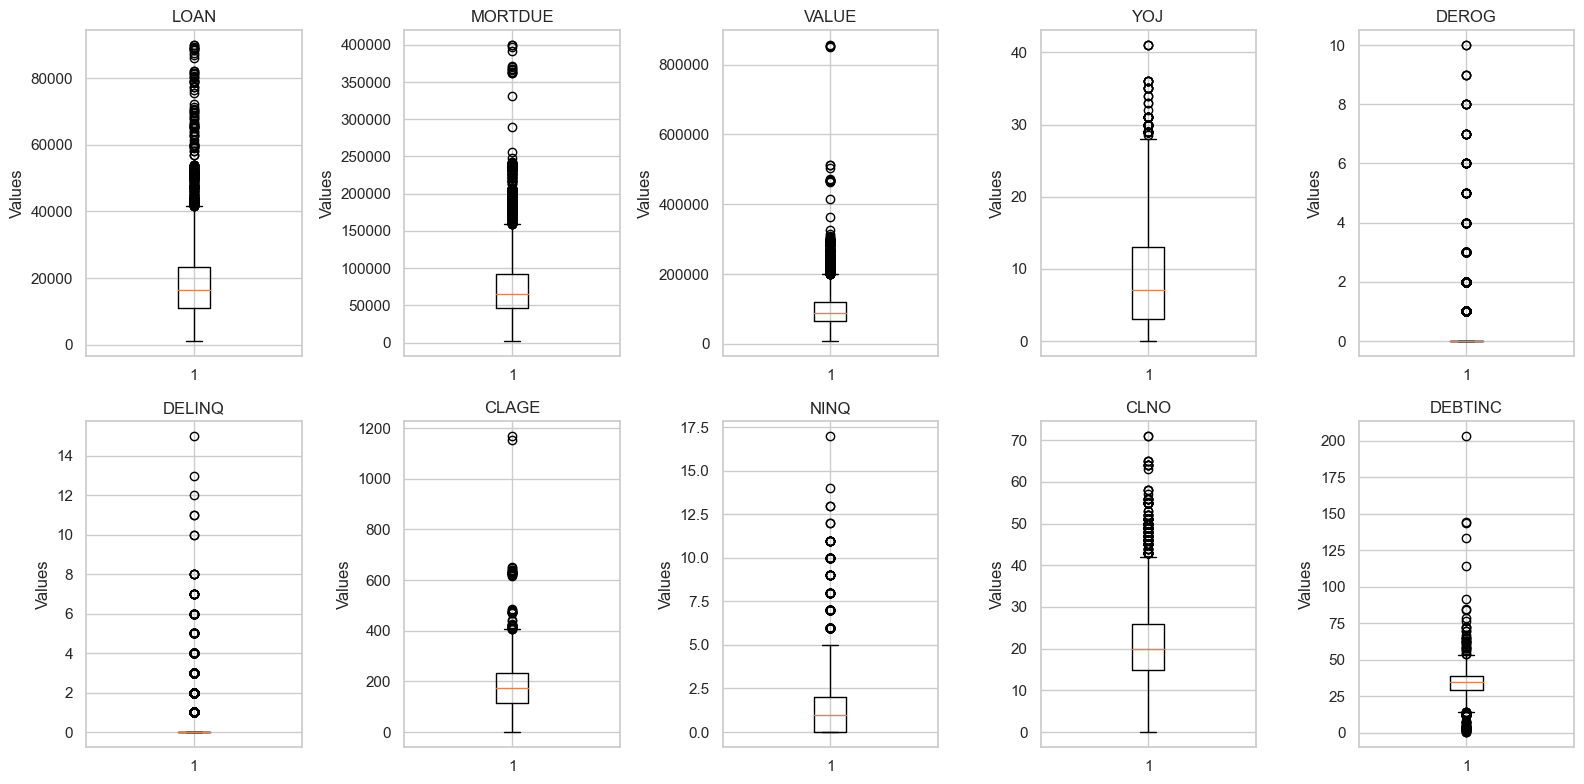

In [37]:
# Specify the numerical columns for which you want to create boxplots
numerical_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

# Determine the number of rows and columns for the subplot grid
n_rows = 2  # Number of rows
n_cols = len(numerical_columns) // n_rows  # Number of columns

# Create individual boxplots for each numerical column arranged horizontally
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 8))

for i, col in enumerate(numerical_columns):
    ax = axes[i // n_cols, i % n_cols]  # Calculate the subplot index
    ax.boxplot(loan_default_df_num[col].dropna())  # Drop NA values for the boxplot
    ax.set_title(col)
    ax.set_ylabel('Values')

plt.tight_layout()  # Adjust layout to prevent overlapping titles and labels
plt.savefig("../visualization/boxplot.png")
plt.show()



In [17]:
#statistics of categorical variables

#frequency
#percentage
#mode
#5960

for variable in categorical_columns:
    print(loan_default_df_cat[variable].value_counts())

BAD
0    4771
1    1189
Name: count, dtype: int64
REASON
DebtCon    3928
HomeImp    1780
Name: count, dtype: int64
JOB
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: count, dtype: int64


In [12]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns

    valuable_features = np.array([])
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        if d['IV'].sum()>0.02:
            valuable_features = np.append(valuable_features, ivars)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF, valuable_features


newDF, woeDF, valuable_features = iv_woe(loan_default_df,"BAD")
newDF.head()
print(valuable_features)

Information value of LOAN is 0.160156
Information value of MORTDUE is 0.05352
Information value of VALUE is 0.112311
Information value of REASON is 0.008843
Information value of JOB is 0.09084
Information value of YOJ is 0.065104
Information value of DEROG is 0.265126
Information value of DELINQ is 0.459917
Information value of CLAGE is 0.238511
Information value of NINQ is 0.166957
Information value of CLNO is 0.080118
Information value of DEBTINC is 0.478596
['LOAN' 'MORTDUE' 'VALUE' 'JOB' 'YOJ' 'DEROG' 'DELINQ' 'CLAGE' 'NINQ'
 'CLNO' 'DEBTINC']
